Model trained on Kaggle P100 GPU

In [1]:
!pip install -U torch==1.12.1 torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 976.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 53.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 58.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0


In [33]:
import random

from collections import Counter
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from torch.optim import lr_scheduler, Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [4]:
sns.set(style='whitegrid', font_scale=1.4)

In [5]:
train_on_gpu = torch.cuda.is_available()
device = 'cpu'
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    device = 'cuda'

CUDA is available!  Training on GPU ...


In [6]:
!nvidia-smi

Sun Nov 20 11:05:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [8]:
train_path = Path('../input/journey-springfield/train/simpsons_dataset')
test_path = Path('../input/journey-springfield/testset/testset')

train_files = sorted(list(train_path.rglob('*.jpg')))
labels = [path.parent.name for path in train_files]
test_files = sorted(list(test_path.rglob('*.jpg')))

In [9]:
raw_labels_data = pd.Series(labels).value_counts().sort_values().to_frame("count")

In [11]:
def plot_labels(labels_data):
    plt.figure(figsize=(20, 10))
    sns.barplot(x=labels_data.index, y=labels_data['count'], orient='v').set_xticklabels(labels_data.index, rotation=90)
    plt.show()

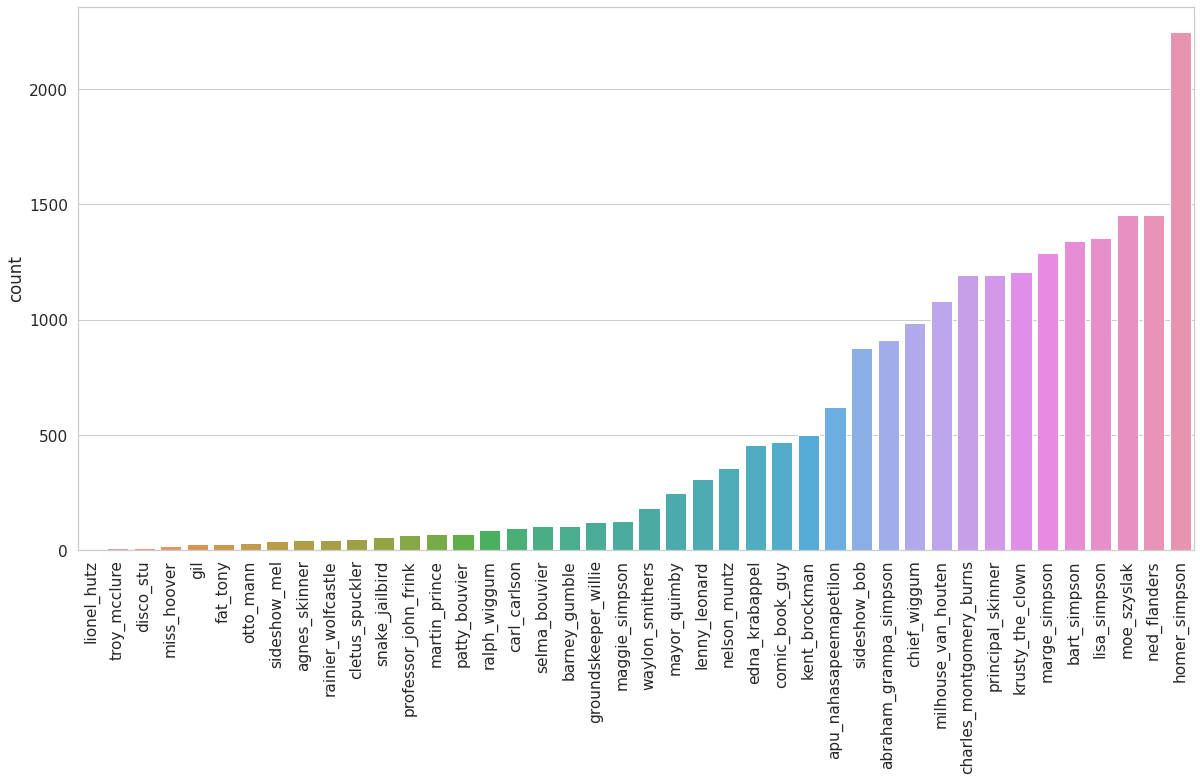

In [12]:
plot_labels(raw_labels_data)

Dataset is very unbalansed, so we will use WeightedRandomSampler to make the number of examples in  all classes greater than 2000

In [13]:
def make_dataset(input_image_size: int = 224):
    augmentations = transforms.RandomChoice([
        transforms.Compose([
            transforms.Resize(size=300, max_size=301),
            transforms.CenterCrop(size=300),
            transforms.RandomCrop(250)
        ]),
        transforms.RandomRotation(degrees=(-25, 25)),
        transforms.RandomHorizontalFlip(p=1),
        ])
    data_transforms = transforms.Compose([
        augmentations,
        transforms.Resize(size=(input_image_size, input_image_size)),
        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
    ])
    train_dataset = datasets.ImageFolder(root=train_path, transform=data_transforms)
    return train_dataset

In [14]:
def make_dataloader(train_dataset):
    class_count = Counter(train_dataset.targets)
    class_weights = {i: 1/c for i, c in class_count.items()}
    sample_weights = [0] * len(train_dataset)
    for i, (data, label) in enumerate(tqdm(train_dataset)):
        sample_weights[i] = class_weights[label]

    num_samples = max(class_count.values()) * len(class_count)  
    train_sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
    train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
    return train_dataloader

Since our goal is to achieve the best prediction on the test set, in this case we will not create a validation set (in the general case, it would be worth doing this to compare different models)

In [15]:
train_dataset = make_dataset()
train_dataloader = make_dataloader(train_dataset)

100%|██████████| 20933/20933 [03:18<00:00, 105.44it/s]


In [16]:
balanced_labels = []
for data, labels in tqdm(train_dataloader):
    balanced_labels += labels.tolist()
balanced_labels = [train_dataset.classes[i] for i in balanced_labels]
balanced_labels_data = pd.Series(balanced_labels).value_counts().sort_values().to_frame("count")

100%|██████████| 2948/2948 [10:48<00:00,  4.54it/s]


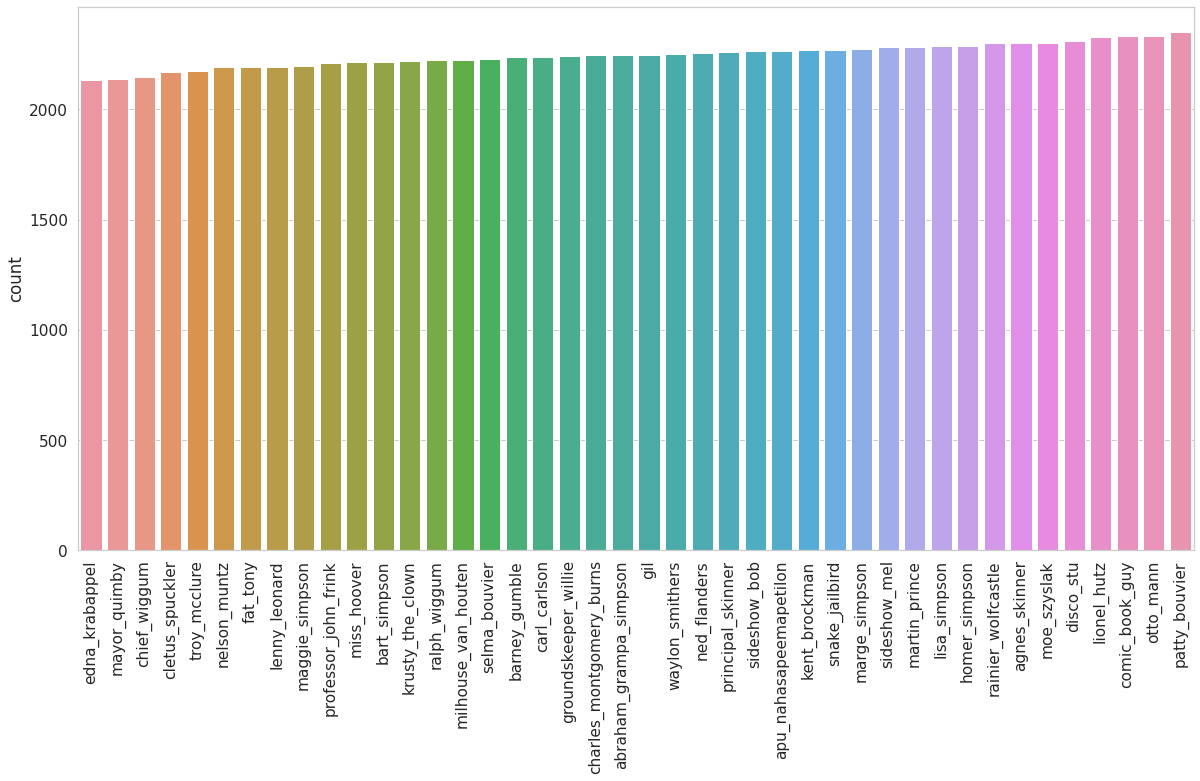

In [17]:
plot_labels(balanced_labels_data)

In [18]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

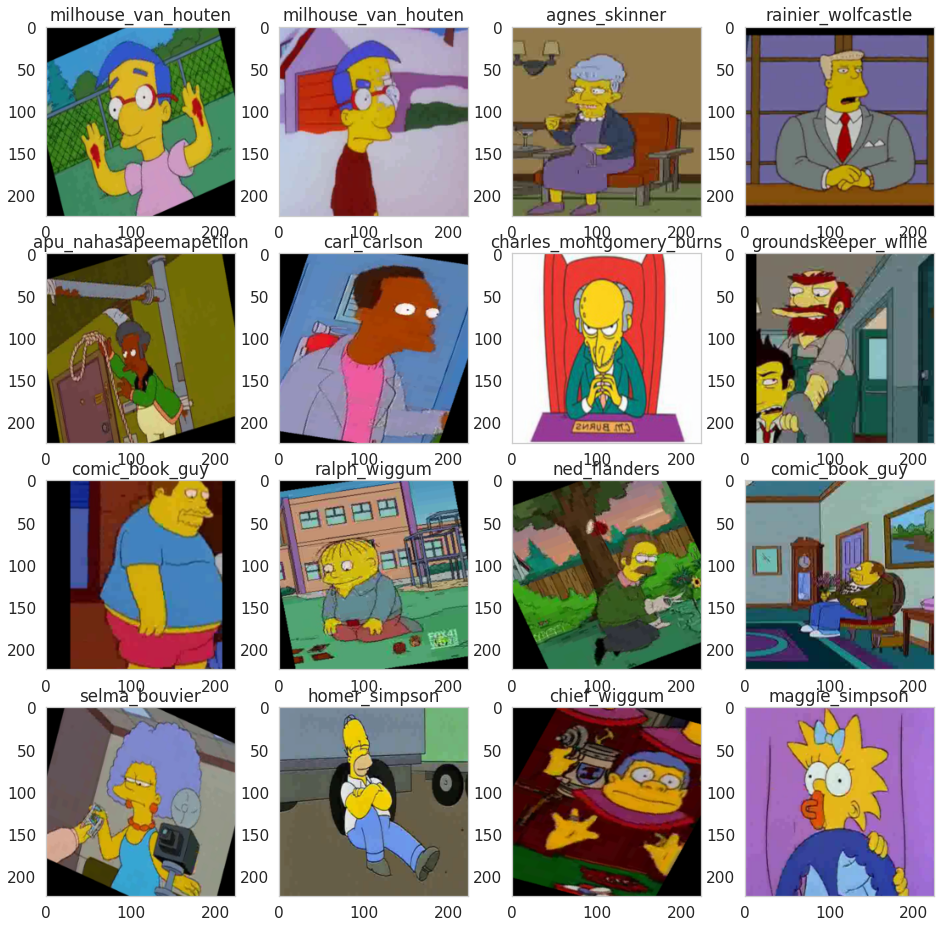

In [19]:
axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))[1]
data, labels = next(iter(train_dataloader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=train_dataset.classes[l], plt_ax=ax)

In [20]:
def step(model, train_dataloader, criterion, optimizer, scheduler, device='cuda'):
    epoch_loss = 0.0
    epoch_correct = 0
    num_samples = 0
  
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.nn.functional.softmax(outputs, dim=-1).argmax(-1)
        epoch_loss += loss.item() * inputs.size(0)
        epoch_correct += torch.sum(preds == labels.data)
        num_samples += inputs.size(0)
              
    scheduler.step()
    train_loss = epoch_loss / num_samples
    train_acc = epoch_correct.cpu().numpy() / num_samples
    return train_loss, train_acc

In [21]:
def train(model, loss, optimizer, scheduler, epochs):
    history = []
    for epoch in tqdm(range(epochs), desc="Training model"):
        train_loss, train_acc = step(model, train_dataloader, loss, optimizer, scheduler, device=device)
        history.append((train_loss, train_acc))
        print(f'Epoch {epoch}: loss {train_loss}, acc {train_acc}')

    return history

In [26]:
model_resnet = models.resnet50(pretrained=True)

for param in model_resnet.parameters():
    param.require_grad = False

num_features = model_resnet.fc.in_features
model_resnet.classifier = torch.nn.Linear(num_features, len(train_dataset.classes))
model_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = Adam(list(model_resnet.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [28]:
history = train(model_resnet, loss_func, optimizer, exp_lr_scheduler, epochs=10)

Training model:  10%|█         | 1/10 [19:13<2:53:02, 1153.56s/it]

Epoch 0: loss 0.17951628860122615, acc 0.9613386761650341


Training model:  20%|██        | 2/10 [38:33<2:34:16, 1157.06s/it]

Epoch 1: loss 0.049832650870419645, acc 0.9869609464444727


Training model:  30%|███       | 3/10 [58:02<2:15:39, 1162.73s/it]

Epoch 2: loss 0.03661688079940845, acc 0.9899397871348005


Training model:  40%|████      | 4/10 [1:17:18<1:55:59, 1159.87s/it]

Epoch 3: loss 0.029845809068081576, acc 0.9919857524487978


Training model:  50%|█████     | 5/10 [1:36:35<1:36:34, 1158.88s/it]

Epoch 4: loss 0.009545162330772825, acc 0.9976148072764279


Training model:  60%|██████    | 6/10 [1:55:49<1:17:09, 1157.43s/it]

Epoch 5: loss 0.004536862015895876, acc 0.9989081117754315


Training model:  70%|███████   | 7/10 [2:15:02<57:47, 1155.78s/it]  

Epoch 6: loss 0.0025564958704094544, acc 0.9993533477504982


Training model:  80%|████████  | 8/10 [2:34:14<38:29, 1154.54s/it]

Epoch 7: loss 0.0018878153961945357, acc 0.99959716745113


Training model:  90%|█████████ | 9/10 [2:53:41<19:18, 1158.68s/it]

Epoch 8: loss 0.0015787854256226468, acc 0.9996183691642284


Training model: 100%|██████████| 10/10 [3:13:30<00:00, 1161.01s/it]

Epoch 9: loss 0.0012426784114053092, acc 0.9996607725904253


In [29]:
loss, acc = zip(*history)

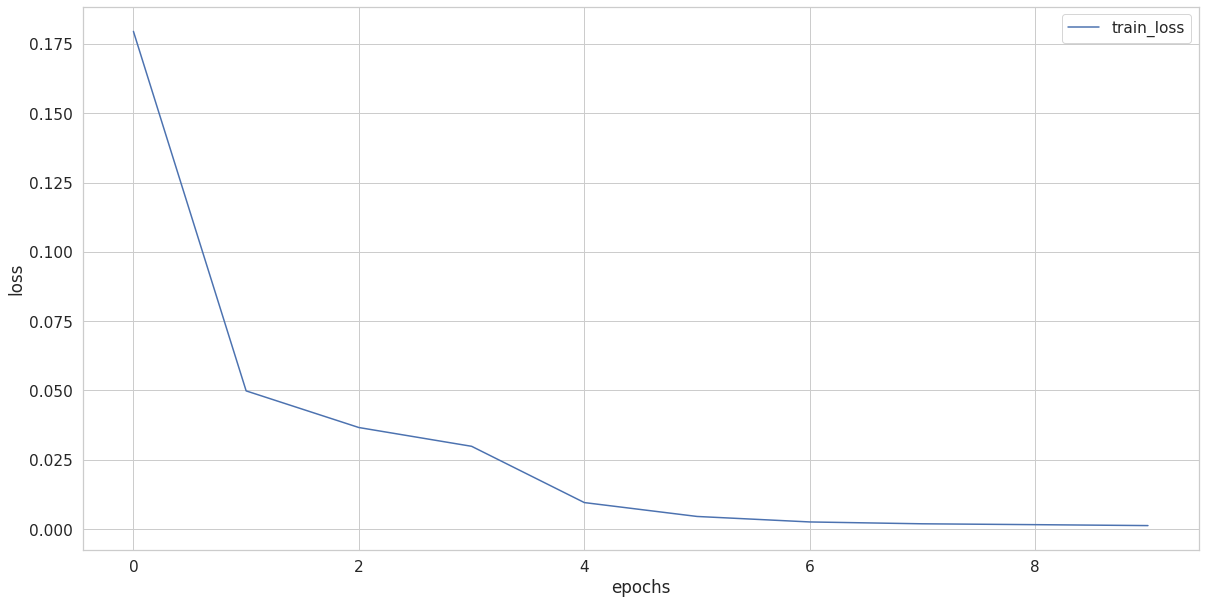

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

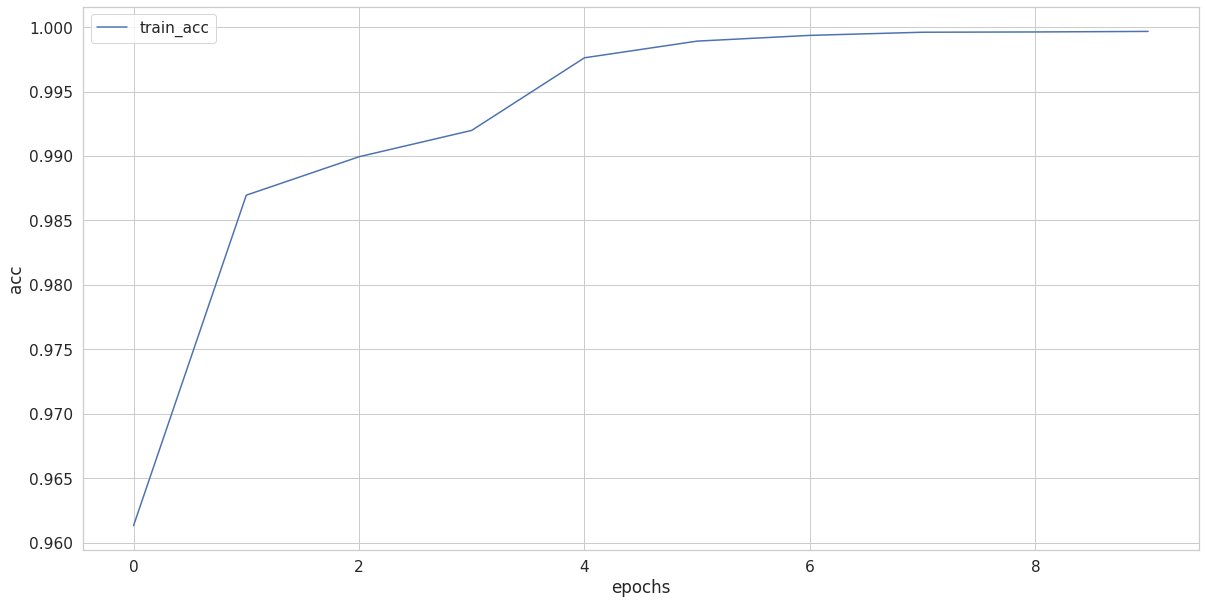

In [31]:
plt.figure(figsize=(20, 10))
plt.plot(acc, label="train_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [39]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [45]:
def predict(model, test_loader, device='cuda'):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [46]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(model_resnet, test_loader, device=device)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [48]:
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("resnet.csv", index=False)

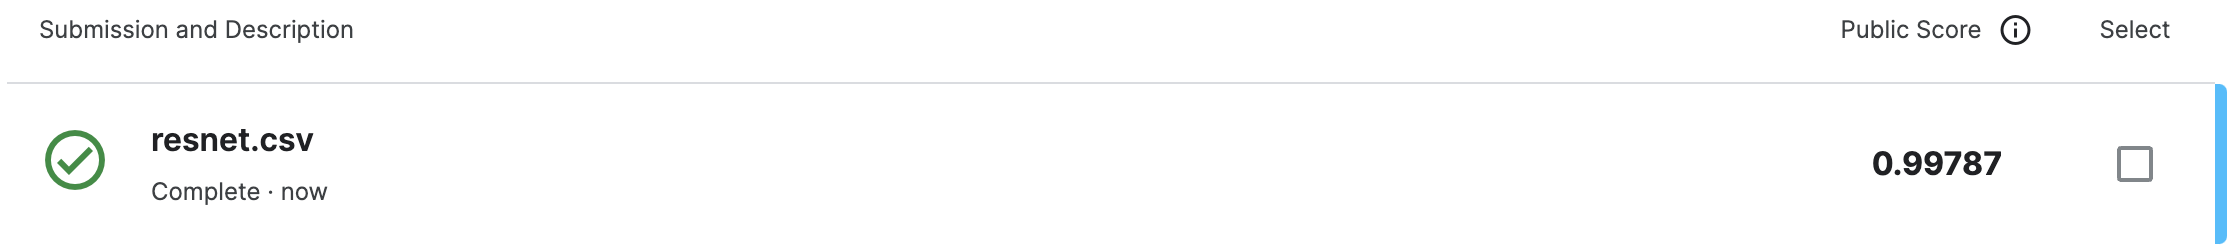